In [176]:
from preprocessing.DataList import *
from preprocessing.DataSet import *
from utility.Solver import *

import cv2
import matplotlib.pyplot as plt
# Set default figure size
plt.rcParams['figure.figsize'] = (10.0, 10.0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extracting the data

In [123]:
# Extract the training data  
labelPath = '/Users/rezaasad/Documents/CMPT742/Project01/data/training_data/LFW_annotation_train.txt'
baseImagePath = '/Users/rezaasad/Documents/CMPT742/Project01/data/lfw'
data = DataList(labelPath, baseImagePath)
# Create a data list
data.MakeList()

We have reached the end of the file


## Visualization of the input
Now let's try to visualize some of the images to make sure they are as expected. Most importantly <br/>
we want to see if the land marks are where they are supposed to be.

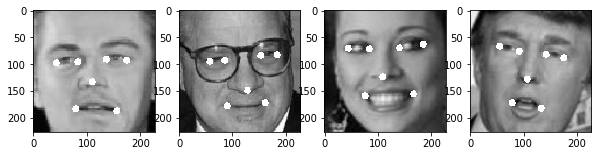

In [124]:
NUM_IMGS = 4
Xsample = data.X[:NUM_IMGS].clone()
ySample = data.y[:NUM_IMGS].clone()
C, H, W = Xsample[0].shape

figs, axes = plt.subplots(1, 4)
for i in range(NUM_IMGS):
    img = np.asarray(Xsample[i].reshape(H, W))
    # Add the landmarks
    landMarks = np.asarray(ySample[i])
    for x,y in landMarks:
        cv2.circle(img, (x,y), 3, 255, thickness=5)
    # Plot the image
    axes[i].imshow(img, cmap='gray')
plt.show()

## Normalizing the images and land mark coordinates

In [125]:
# I normalize the images to be in range [-1, 1] and the landmarks to 
# be in range [0, 1]
data.ScaleImages()

## Splitting data to train and validation

In [126]:
data.DataSplit()

## Let's feed the data to DataLoader

In [179]:
from torch.utils.data import DataLoader

trainDataSet = LFWDataset(data.Xtrain, data.yTrain)
valDataSet = LFWDataset(data.Xval, data.yVal)
solver = Solver(trainDataSet, valDataSet, batchSize=64)

The batch has shape: torch.Size([64, 1, 227, 227])
There are 14 land mark coordinates on each face


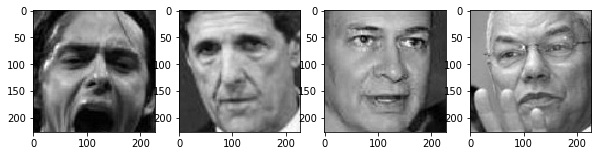

In [181]:
# Now I'm going to read a few data examples from the DataLoader and plot them
idx, (img, landMarks) = next(enumerate(solver.trainLoader))

print("The batch has shape: {}".format(img.shape))
print("There are {} land mark coordinates on each face".format(len(landMarks[0])))

NUM_IMGS = 4
N, C, H, W = img.shape
figs, axes = plt.subplots(1, NUM_IMGS)
for i in range(NUM_IMGS):
    axes[i].imshow(img[i].reshape(H, W), cmap='gray')
plt.show()